# Introduction

<p>
    I was inspired by <a href="https://towardsdatascience.com/real-time-face-recognition-an-end-to-end-project-b738bb0f7348">this</a> article to try my hand at facial recognition. This notebook contains an app in two parts. The first uses a webcam and face detection to take mug shots of the user which are used to train a recognizer. The second part also uses face detection, but now uses the trained recognizer to predict whether the detected faces are in the training set.
</p>

<p>
    <center>
        <figure style="display: inline-block">
            <img src="demo_images/register_demo.gif" width="300" height="auto" />
            <figcaption>Registering a new user</figcaption>
        </figure>
        <figure style="display: inline-block">
            <img src="demo_images/single_direct.gif" width="300" height="auto" />
            <figcaption>Authenticating a user</figcaption>
        </figure>
    </center>
</p>

## Requirements

<p>This notebook was written with Python 3.8.0 and the following libraries. If you have difficulties running it with other versions, try using a virtual environment and running this cell.</p>

<p><strong>Note:</strong> The code depends on a local webcam, so this won't work in Google Colab or other web-based environments.</p>

In [ ]:
!pip3 install opencv-contrib-python==4.8.0.76 imutils==0.5.4 matplotlib==3.7.3 numpy==1.24.4 imageio==2.31.5

## Imports

In [1]:
import datetime
import math
import os
import random
import re
import sys
import time
from typing import Any, Dict, List, Tuple, Union

import cv2
import imageio
import imutils
import matplotlib.pyplot as plt
import numpy as np
from imutils.video import VideoStream

%matplotlib inline

## File paths

Let's download haarcascade_frontalface_default.xml, used for face detection, if we haven't already, and set some file paths that we'll need later.

In [2]:
# The Haar cascade file
CASCADE_PATH = os.path.join(os.getcwd(), "haarcascade_frontalface_default.xml")
CASCADE_URL = "https://raw.githubusercontent.com/kipr/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
if not os.path.exists(CASCADE_PATH):
    !wget {CASCADE_URL}

# Trained face data
FACE_DATA = os.path.join(os.getcwd(), "face_data.yml")

# Location for user images
SAVE_PATH = os.path.join(os.getcwd(), "user_pics")

# Filename format for user images
PIC_FILE_TEMPLATE = "user_{0}_pic_{1}.jpg"
PIC_FILE_RE = PIC_FILE_TEMPLATE.format("(\d+)", "\d+")

# Location of target images for gridsearch
GRIDSEARCH_IMAGES = os.path.join(os.getcwd(), "gridsearch_images")

# Folder for narrative images
DEMO_IMAGES = os.path.join(os.getcwd(), "demo_images")

## Saving Images

These methods cover the saving of the user pics and gif recordings.

In [ ]:
def get_next_user_id() -> int:
    """
    Return the next available user ID (first is 1)
    """

    next_id = 1
    for file in sorted(os.listdir(SAVE_PATH)):
        match = re.search(PIC_FILE_RE, file)
        if match:
            if int(match.groups()[0]) == next_id:
                next_id += 1
    return next_id


def save_user_images(img_list: List[np.ndarray]) -> None:
    """
    Save the given list of images to the save directory with a unique prefix
    """
    
    # Make sure the save directory exists
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

    # Save the mug shots with a unique user ID
    next_id = get_next_user_id()
    for i, img in enumerate(img_list):
        cv2.imwrite(os.path.join(SAVE_PATH, PIC_FILE_TEMPLATE.format(next_id, i)), img)

    # Display the captured mug shots (or 10 random ones if there are more than that)
    max_displayed_shots = 10
    if len(img_list) > max_displayed_shots:
        img_list = random.sample(img_list, k=max_displayed_shots)
    rows = 2
    cols = int(len(img_list) / rows)
    fig = plt.figure(figsize=(10, 6))
    for i in range(0, rows * cols):
        img = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB)  # Because CV2 captures in BGR, but plt uses RGB
        fig.add_subplot(rows, cols, i + 1)
        plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        plt.imshow(img)
    plt.show()
    plt.close()


def save_gif(frames: List[np.ndarray],
             name: str) -> None:
    """
    Shrink and colour correct the frames before saving them as a gif
    """
    
    resized_frames = [imutils.resize(frame, width=300) for frame in frames]
    corrected_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in resized_frames]
    imageio.mimwrite(name, corrected_frames, fps=30, loop=0)

# Video Capture

In [ ]:
# How many mug shots to take
MAX_SHOTS = 10

# Random value in [0, 1) must be greater than this to capture mug shot
CAPTURE_THRESHOLD = 0.9

# How big to resize the frame
FRAME_WIDTH = 600

# To colour the frame around the face
USER_COLOURS = [(255, 128, 255), (255, 255, 0)]

# The capture loop acts differently depending on the mode
MODE_WAITING = 0
MODE_LEFT_RIGHT = 1
MODE_UP_DOWN = 2
MODE_AUTHENTICATING = 3

# These are used to instruct the user when registering
MESSAGES = ["Press S when ready to begin",
            "Move your head left and right",
            "Move your head up and down",
            ""]

def add_text(frame: np.ndarray,
             message: str) -> None:
    """
    Add the message at bottom centre of the frame
    """
    
    # Text Options
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1
    thickness = 2
    colour = (255, 255, 255)

    # Find the bottom centre of the frame
    text_size = cv2.getTextSize(message, font, scale, thickness)[0]
    x_pos = int((frame.shape[1] - text_size[0]) / 2)
    y_pos = frame.shape[0] - 20

    # Add the text
    cv2.putText(frame, message, (x_pos, y_pos), font, scale, colour, thickness)


def capture_frame(stream: VideoStream,
                  cascade: cv2.CascadeClassifier) -> (np.ndarray, np.ndarray, Tuple[np.ndarray]):
    """
    Get the next frame from the stream, mirror it, resize it, and convert it to greyscale
    Find the faces in the frame
    Return frame, grayscale version, and bounding boxes of faces
    """

    frame = cv2.flip(stream.read(), 1)
    frame = imutils.resize(frame, width=FRAME_WIDTH)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = cascade.detectMultiScale(
        gray_frame,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(100, 100)
    )

    return frame, gray_frame, faces


def get_mug_shot(frame: np.ndarray,
                 gray_frame: np.ndarray,
                 face: Tuple[int]) -> Union[np.array, None]:
    """
    Draw a rectangle around the face in the frame.
    With some probability, capture and return this mug shot
    """

    # Unpack the bounding box
    x_pos, y_pos, width, height = face

    # Draw a rectangle around the face.
    frame = cv2.rectangle(frame, (x_pos, y_pos), (x_pos + width, y_pos + height), (255, 255, 255), 2)

    # If the threshold is passed, capture the mug shot
    if np.random.random() > CAPTURE_THRESHOLD:
        return gray_frame[y_pos:y_pos + height, x_pos:x_pos + width]

    return None


def main(current_mode: int,
         recognizer: cv2.face.LBPHFaceRecognizer = None) -> None:
    """
    MODE_WAITING:                  Detect faces and draw bounding boxes
    MODE_UP_DOWN|MODE_LEFT_RIGHT:  Sample mug shots if single face detected
    MODE_AUTHENTICATING:           Detect faces and predict label/confidence
    """

    # Initialise the webcam
    stream = VideoStream(src=0, framerate=30).start()

    # Initialise the classifier for detecting faces
    cascade = cv2.CascadeClassifier(CASCADE_PATH)

    # Set the frame title by mode
    # Initialise a list for the mug shots
    if current_mode == MODE_WAITING:
        mug_shots = []
        frame_title = "Register New User"
    elif current_mode == MODE_AUTHENTICATING:
        frame_title = "Authenticate User"

    # Keep a list of frames for a gif
    all_frames = []

    # Whether to save frames to produce a gif
    recording = red_circle = False

    while True:
        # Capture the frame, a gray scale version, and anhy faces in it
        frame, gray_frame, faces = capture_frame(stream, cascade)

        # Waiting to begin capturing new user images; put a bounding box around all faces
        if current_mode == MODE_WAITING:
            for (x_pos, y_pos, width, height) in faces:
                frame = cv2.rectangle(frame, (x_pos, y_pos), (x_pos + width, y_pos + height), (255, 255, 255), 2)

        # In capture mode (LEFT_RIGHT|UP_DOWN) and only 1 face
        elif current_mode <= MODE_UP_DOWN and len(faces) == 1:
            # Add the mug shot (if one is captured) to the list; check for switching to next mode/finishing
            mug_shot = get_mug_shot(frame, gray_frame, faces[0])
            if mug_shot is not None:
                mug_shots.append(mug_shot)
                if len(mug_shots) == int(MAX_SHOTS / 2):
                    current_mode = MODE_UP_DOWN
                elif len(mug_shots) == MAX_SHOTS:
                    save_user_images(mug_shots)
                    break

        # Trying to recognize known users
        elif current_mode == MODE_AUTHENTICATING:
            for (x_pos, y_pos, width, height) in faces:
                # Predict a label and confidence for each face detected
                label, confidence = recognizer.predict(gray_frame[y_pos:y_pos + height, x_pos:x_pos + width])

                colour = USER_COLOURS[label - 1]

                # Draw a rectangle around this face with the predicted label/unknown and confidence
                frame = cv2.rectangle(frame, (x_pos, y_pos), (x_pos + width, y_pos + height), colour, 2)
                cv2.putText(frame,
                            f"User {label} ({confidence})",
                            (x_pos + 5, y_pos + height + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, colour, 2)

        # Add appropriate message to the frame
        add_text(frame, MESSAGES[current_mode])

        # If recording is True, add a blinking red circle to the top right and keep the frame
        if recording:
            # Blinking red circle
            if len(all_frames) % 30 == 0:
                red_circle = not red_circle
            if red_circle:
                all_frames.append(np.copy(frame))  # Save a copy without the red circle
                cv2.circle(frame, (FRAME_WIDTH - 20, 20), 10, (0, 0, 255), -1)
            else:
                all_frames.append(frame)

        # Display the frame
        cv2.imshow(frame_title, frame)

        # Check for a key press
        key = cv2.waitKey(1) & 0xFF

        # User is ready and presses 's'
        if current_mode == MODE_WAITING and key == ord("s"):
            current_mode = MODE_LEFT_RIGHT

        # Save a screen grab of the frame named for the current time
        elif key == ord("p"):
            name = f"{datetime.datetime.now().time().strftime('%H_%M_%S')}.jpg"
            cv2.imwrite(os.path.join(os.getcwd(), name), frame)

        # Start/stop recording
        elif key == ord("r"):
            recording = not recording
            red_circle = recording

        # Quit
        elif key == ord("q"):
            break

    # Tidy up CV2 and the VideoStream
    cv2.destroyAllWindows()
    stream.stop()

    # If frames have been recorded, save them as a gif
    if len(all_frames) > 0:
        gif_path = os.path.join(os.getcwd(), "recording.gif")
        save_gif(all_frames, gif_path)


def register_user() -> None:
    """
    Convenience wrapper for adding a user
    """
    main(MODE_WAITING)


def authenticate_user(recognizer: cv2.face.LBPHFaceRecognizer) -> None:
    """
    Convenience wrapper for starting facial recognition
    """
    main(MODE_AUTHENTICATING, recognizer=recognizer)

# Face Detection

## Haar Cascade Classifier
<p>
    OpenCV provides a pre-trained model, <a href="https://github.com/kipr/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml">haarcascade_frontalface_default.xml</a>, for use with <a href="https://docs.opencv.org/4.8.0/db/d28/tutorial_cascade_classifier.html">cv2.CascadeClassifier</a>.
    The Haar Cascade was proposed by Paul Viola and Michael Jones in their 2001 paper <a href="https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/3_dim_reduction/notes_slides/viola-cvpr-01.pdf">Rapid Object Detection using a Boosted Cascade of Simple Features</a>. There's an excellent explanation in <a href="https://medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d">this</a> article, but to summarise, the technique computes <a href="https://en.wikipedia.org/wiki/Haar-like_feature">Haar features</a> over an <a href="https://en.wikipedia.org/wiki/Summed-area_table">integral image</a>, and uses a modified <a href="https://en.wikipedia.org/wiki/AdaBoost">AdaBoost</a> create a series of cascading classifiers. At each stage of the cascade, if a region is determined not to contain an object, it does not progress to the next stage. This is a type of attentional mechanism to make the algotithm focus on the regions most likely to contain a face.
</p>

<p>
    The <em>register_user()</em> method in the next cell starts the video capture, with an example in this gif. The face detected by the Haar Cascade is surrounded with a bounding box, and mug shots are taken randomly to get a variety of angles.<br/>
    <img src="demo_images/register_demo.gif" />
    
</p>
<p>
    Here are a sample of the captured images which will be used to train the recognizer.
    <img src="demo_images/mug_shot_samples.png" />
</p>

In [ ]:
register_user()

# Facial Recognition

## Local Binary Pattern Histogram (LBPH)

<p>
Fuller explanations are found in <a href="http://www.scholarpedia.org/article/Local_Binary_Patterns">this</a> article and <a href="https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b">this</a>, but briefly, LBPH captures the unique texture of a person's face by breaking down the image into smaller regions and analyzing the patterns within those regions. These patterns, represented as binary values, are then used to construct a histogram for each face in a training dataset. When it comes to recognizing a face, LBPH computes the histogram for a test image and compares it to the histograms of known faces. LBPH is robust enough to handle variations in lighting, facial expressions, and minor changes in pose.
</p>

<p>
OpenCV implements LPBH as <a href="https://docs.opencv.org/4.8.0/df/d25/classcv_1_1face_1_1LBPHFaceRecognizer.html">cv2.face.LBPHFaceRecognizer</a> whose <a href="https://docs.opencv.org/4.8.0/df/d25/classcv_1_1face_1_1LBPHFaceRecognizer.html#ac33ba992b16f29f2824761cea5cd5fc5">parameters</a> are listed below. Let's keep these at the default values for now.

| Name       | Purpose |
| --------   | ------- |
| radius     | the radius around the central pixel |
| neighbours | the number of sample points |
| grid_x     | the number of features horizontally |
| grid_y     | the number of features vertically |
| threshold  | the confidence cutoff for recognition |

</p>

In [3]:
def create_recognizer(face_data_path: str = None,
                     radius:int = 1,
                     neighbours:int = 8,
                     grid_xy:int = 8,
                     threshold:float = sys.float_info.max) -> cv2.face.LBPHFaceRecognizer:
    """
    Return a new LBPHFaceRecognizer.
    If a path for data is given, load it
    """

    recognizer = cv2.face.LBPHFaceRecognizer_create(radius=radius,
                                                   neighbors=neighbours,
                                                   grid_x=grid_xy,
                                                   grid_y=grid_xy)
    if face_data_path:
        recognizer.read(face_data_path)
    return recognizer

## Training

<p>
The mug shots saved in the earlier step are loaded and the integer label extracted from the filename. The <a href="https://docs.opencv.org/4.8.0/dd/d65/classcv_1_1face_1_1FaceRecognizer.html#ac8680c2aa9649ad3f55e27761165c0d6"><i>train()</i></a> method (inherited from <a href="https://docs.opencv.org/4.8.0/dd/d65/classcv_1_1face_1_1FaceRecognizer.html">cv2.face.FaceRecognizer</a>) accepts the mug shots taken earlier to compute the LBPHs and creates a YAML file containing the histograms and the labels.

</p>

In [ ]:
def load_users() -> (List[np.array], np.array):
    """
    Return the user images and labels
    """

    faces = []
    labels = []

    for file in sorted(os.listdir(SAVE_PATH)):
        match = re.search(PIC_FILE_RE, file)
        if match:
            # Read in grayscale image and convert to numpy array
            img = cv2.imread(os.path.join(SAVE_PATH, file), cv2.IMREAD_GRAYSCALE)
            img_numpy = np.array(img, "uint8")
            faces.append(img_numpy)

            # Get the ID of the user from the filename
            u_id = int(match.groups()[0])
            labels.append(u_id)

    return faces, np.array(labels)


# Load the user images and labels
faces, labels = load_users()

# Create and train the recognizer
recognizer = create_recognizer(radius=2, neighbours=2, grid_xy=2)
recognizer.train(faces, labels)

# Write the recognizer data to file
recognizer.write(FACE_DATA)

### YAML

<p>
The start and end of the yaml file contain some metadata, and between the two, a list of numpy arrays. The following is from a single training image.
</p>

In [4]:
!head -n 15 {FACE_DATA}

%YAML:1.0
---
opencv_lbphfaces:
   threshold: 1.7976931348623157e+308
   radius: 2
   neighbors: 2
   grid_x: 2
   grid_y: 2
   histograms:
      - !!opencv-matrix
         rows: 1
         cols: 16
         dt: f
         data: [ 1.30569771e-01, 4.15266633e-01, 2.41417095e-01,
             2.12746546e-01, 1.24360852e-01, 3.46603364e-01,


In [5]:
!tail -n 10 {FACE_DATA}

             3.90955657e-01, 2.92715520e-01, 1.81554914e-01,
             1.57718867e-01, 3.40833127e-01, 2.87369102e-01,
             2.14078858e-01 ]
   labels: !!opencv-matrix
      rows: 2
      cols: 1
      dt: i
      data: [ 1, 2 ]
   labelsInfo:
      []


## Authenticating
<p>
This step loads the previously computed LBPH and compares them to faces detected in the webcam. The gif shows the face detected and recognized as User 1 with a confidence level around 40 (0 would a perfect match).
</p>

<p>
    <center>
        <img src="demo_images/single_direct.gif" width="300" height="auto" style="display: inline"/>
    </center>
</p>

In [ ]:
# Create the recognizer with the computed histograms
# No need to pass radius, etc, as these are loaded from the yaml
recognizer = create_recognizer(FACE_DATA)

authenticate_user(recognizer)

# Experiments

## Single vs Mulitple Input Images

<p>
There are two models here - the Single Input Image Model (SIIM) and the Multiple Input Image Model (MIIM)
Here is a side by side comparison of the model's confidence when a single frontal image has been used (User 1) versus multiple images from various angles (User 2).</p>

<p>
The confidence is about the same when the user looks head-on, because both models have a head-on mug shot of the user. However, as the user moves left/right/up/down, there is a difference of between the two models. The single input model now demonstrates the robustness to pose mentioned above, but of course is less confident of its prediction, while the MIIM has seen examples much closer to the target pose and is more confident. The MIIM is still less confident about the left/right/up poses because the LBPH depends on certain characteristics of the face, including its symmetry. As the face moves, this symmetry is broken so the confidence goes down, while still being better than the SIM extrapolating from a single image.
</p>

<p> Finally, the down pose of the MIM shows a better confidence than even the head-on shot. This bounding box is cropped much more tightly to the face, removing extraneous information, and the glare on the forehead and side of face seen in the other images is almost entirely gone thanks to this angle, making the prediction much easier.
</p>

<table>
    <tr align="center">
        <td><img src="demo_images/single_input.jpg" width="100" height="auto" style="display: inline" /></td>
        <td><img src="demo_images/mug_shot_samples.png" width="400" height="auto" style="display: inline" /></td>
    </tr>
    <tr><th>Single Input Image</th><th>Mulitple Input Images</th></tr>
    <tr>
        <td><img src="demo_images/single_direct.jpg" width="400" height="auto" style="display: inline"/></td>
        <td><img src="demo_images/multiple_direct.jpg" width="400" height="auto" style="display: inline"/></td>
    </tr>
    <tr>
        <td><img src="demo_images/single_left.jpg" width="400" height="auto" style="display: inline"/></td>
        <td><img src="demo_images/multiple_left.jpg" width="400" height="auto" style="display: inline"/></td>
    </tr>
    <tr>
        <td><img src="demo_images/single_right.jpg" width="400" height="auto" style="display: inline" /></td>
        <td><img src="demo_images/multiple_right.jpg" width="400" height="auto" style="display: inline" /></td>
    </tr>
    <tr>
        <td><img src="demo_images/single_up.jpg" width="400" height="auto" style="display: inline" /></td>
        <td><img src="demo_images/multiple_up.jpg" width="400" height="auto" style="display: inline" /></td>
    </tr>
    <tr>
        <td><img src="demo_images/single_down.jpg" width="400" height="auto" style="display: inline" /></td>
        <td><img src="demo_images/multiple_down.jpg" width="400" height="auto" style="display: inline" /></td>
    </tr>
</table>

## Other Users

<p>
The confidence here is not as high as the previous section. Both users have a single mug shot taken head-on to the camera, but the recognition takes place from off-centre. This change in lighting (more glare on the left, less on the right) and angle reduces the confidence somewhat. 
</p>

<table>
    <tr>
        <td>
            <img src="demo_images/mug_shot_darrell.jpg" width="139" height="auto" style="display: inline" /><br/>
            <img src="demo_images/single_input.jpg" width="139" height="auto" style="display: inline" />
        </td>
        <td>
            <img src="demo_images/two_users.jpg" width="500" height="auto" />
        </td>
    </tr>
</table>

<p>
Thanks to Darrell for helping with this section.
</p>

## Photos
When presented with a photo on a phone, the LBPHFaceRecognizer is less confident but still recognises User 1, although this is at least partly due to the lighting and glare from the phone. High quality photos have been known to <a href="https://www.theregister.com/2019/01/04/photos_trick_smartphones/">fool phones with face unlock</a>. However, it also mistakenly recognises a picture of Tom Hanks as User 1 with not much of a drop in confidence. 
<p>
    <center>
        <img src="demo_images/photo_user.jpg" width="400" height="auto" style="display: inline" />
        <img src="demo_images/photo_tom_hanks.jpg" width="400" height="auto" style="display: inline" />
    </center>
</p
<p>
Image of Tom Hanks from <a href="https://www.cleveland.com/tv/2010/02/backstage_with_tom_hanks_inter.html">Cleveland.com</a></p>

## Grid Search

<p>
The best parameters for cv2.face.LBPHFaceRecognizer will depend on the intended usage particulars such as camera resolution, lighting, etc. Let's examine some combinations with a grdisearch, using the values <em><strong>P</strong>={1, 2, 4, 6, 8, 10, 12, 14, 16}</em> for radius, neighbours, and grid_x/grid_y (keeping grid_x = grid_y), for a total of 8^3=512 models.
</p>

<p>
For each parameter combination of <em>(radius, neighbours, grid)</em>, we get the average confidence for identifying a single input image as each of 100 mugshots of user Steve at various angles (a sample of which are shown here).
</p>

<p>
    <img src="demo_images/mug_shot_samples.png" width="500" height="auto" />
</p>

<p>
<strong>Note:</strong> A lower score is better (remember that a perfect match is 0), but because it's more intuitive to have better scores visually higher, plots are drawn with the y-axis inverted. When saying that one score is "higher" than another, we mean "better" rather than mathematically "greater than".
</p>

In [6]:
def gridsearch(face: List[np.array],
               label: np.array,
               gs_values: List[int]) -> Dict[Tuple[int, int, int], float]:
    """
    Execute a gridsearch with the given face and parameters values
    """

    # Load 100 images facing random directions
    test_images = [cv2.imread(os.path.join(GRIDSEARCH_IMAGES, f"gridsearch_{i}.jpg"), cv2.IMREAD_GRAYSCALE) for i in range(100)]

    results = dict()
    for r in gs_values:
        for n in gs_values:
            for g in gs_values:
                # Create recognizer for this tuple of (radius, neighbours, grid)
                recognizer = create_recognizer(radius=r, neighbours=n, grid_xy=g)
                recognizer.train(face, label)

                # Get average prediction confidence
                confs = 0.0
                for img in test_images:
                    _, confidence = recognizer.predict(img)
                    confs += confidence
                avg_confidence = confs / len(test_images)
                results[(r, n, g)] = avg_confidence
    return results


def load_single_user(filename: str) -> (List[np.array], np.array):
    """
    Return a single mugshot from the demo_images folder as a numpy array, with label=1
    """
    filepath = os.path.join(DEMO_IMAGES, filename)
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_numpy = np.array(img, "uint8")

    return [img_numpy], np.array([1])


def plot_confs(steve: List[float],
               darrell: List[float],
               limit: int) -> None:
    """
    Plot the two given lists of floats up to limit
    """
    plt.plot(steve[:limit], label="Steve")
    plt.plot(darrell[:limit], label="Darrell")
    plt.ylabel("Confidence")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title("Average Confidences")


def plot_stats(stats: List[List[float]],
               values: List[int],
               title: str) -> None:
    """
    Box plot the given stats
    """
    plt.boxplot(stats)
    plt.xticks([tick for tick in range(1, len(values) + 1)], values)
    plt.xlabel(r"p $\in$ P")
    plt.ylabel("Confidence")
    plt.gca().invert_yaxis()
    plt.title(title)

### Best Result
<p>
We have two test users, Steve and Darrell, who look quite similar, and we find that the best confidence is for Darrell!
</p>

<p>
<center>
    <figure style="display: inline-block">
        <img src="demo_images/single_input.jpg" width="125" height="auto" />
        <figcaption>Steve</figcaption>
    </figure>
    <figure style="display: inline-block">
        <img src="demo_images/mug_shot_darrell.jpg" width="125" height="auto" />
        <figcaption>Darrell</figcaption>
    </figure>
</center>
</p>


In [7]:
def get_best(results: Dict[Tuple[int, int, int], float]) -> Tuple[Tuple[int, int, int], float]:
    """
    Return the best (r, n, g) and it's confidence
    """
    best_key = None
    best_val = sys.float_info.max
    for key, val in results.items():
        if val < best_val:
            best_key = key
            best_val = val
            
    return best_key, best_val


# The gridsearch parameter values (used for radius, neighbour, and grid)
gs_values = [1, 2, 4, 8, 10, 12, 14, 16]

# Run the gridsearch for Steve and show best result
face_steve, label_steve = load_single_user("single_input.jpg")
results_steve = gridsearch(face_steve, label_steve, gs_values)
best_key_steve, best_val_steve = get_best(results_steve)
print(f"Best result for Steve:   {best_key_steve} {best_val_steve}")

# Run the gridsearch for Darrell and show best result
face_darrell, label_darrell = load_single_user("mug_shot_darrell.jpg")
results_darrell = gridsearch(face_darrell, label_darrell, gs_values)
best_key_darrell, best_val_darrell = get_best(results_darrell)
print(f"Best result for Darrell: {best_key_darrell} {best_val_darrell}")

Best result for Steve:   (4, 1, 1) 0.0008739488314728171
Best result for Darrell: (1, 1, 1) 0.0006624874150535598


### Averages
<p>
Let's look at the results more closely. The left-hand plot shows the 25 best confidences for Steve and Darrell, while the right-hand plot shows the larger picture of all 512 average confidences. 
</p>

<p>
As seen above, the best score is for Darrell, despite the target images all being of Steve. After this, scores for Darrell are worse, but not by a large amount.
</p>

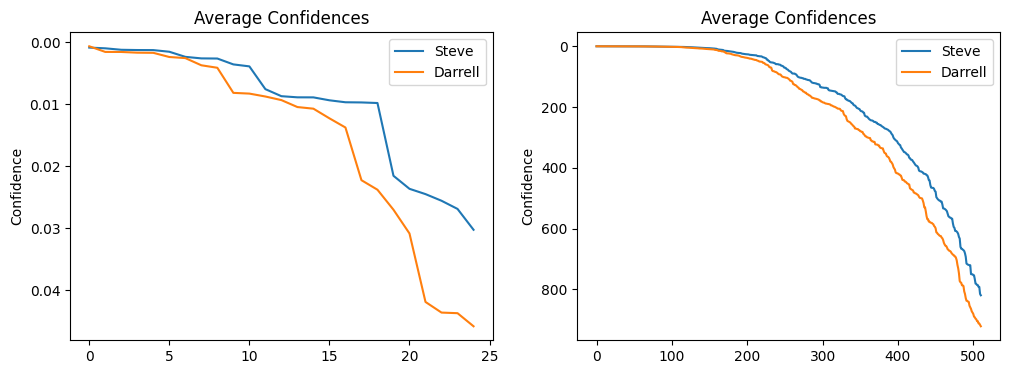

In [8]:
# Sort and plot the confidences
confs_steve = sorted([val for _, val in results_steve.items()])
confs_darrell = sorted([val for _, val in results_darrell.items()])

plt.figure(figsize=(12, 4))
for idx, limit in enumerate([25, -1]):
    plt.subplot(1, 2, idx + 1)
    plot_confs(confs_steve, confs_darrell, limit)
plt.show()

### Parameters

<p>
For each user and for each parameter, we create a box-and-whisker plot for each <em>p&isin; <strong>P</strong></em>.
</p>

<p>
Comparing the results for Steve versus Darrell, the plots have very similar profiles. The main difference is that the results for Darrell are more spread out, and they have fewer outliers because worse scores are to be expected when identifying the wrong person.
</p>

<p>
Focusing on the results for Steve, the parameter with the least impact is <em>radius</em>. Although <em>radius=1</em> has the best scores, once you get to <em>radius>2</em>, there's little change in results. More impactful is <em>neighbours</em>; the best scores are at <em>neighbours=1</em>, and the spread increases quickly as <em>neighbours</em> grows. The parameter with the greatest impact is <em>grid</em>, with the spread of scores worsening rapidly as <em>grid</em> increases.
</p>

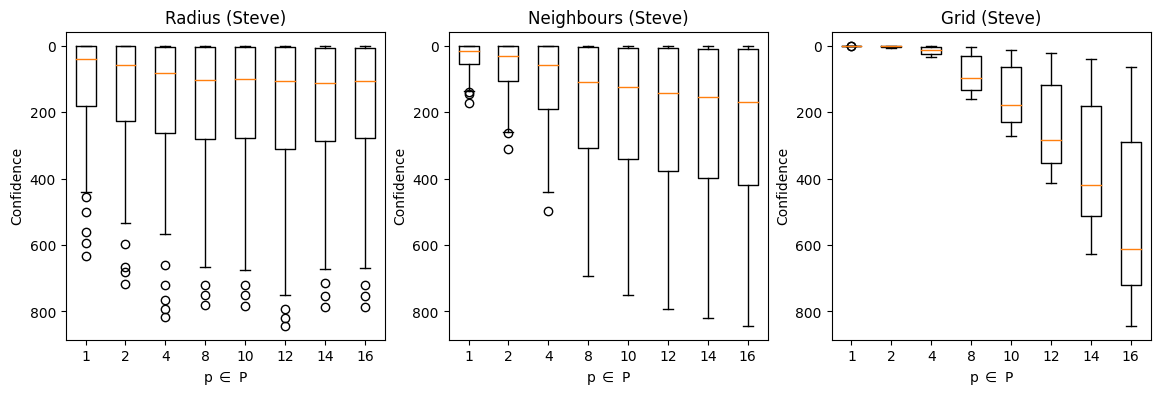

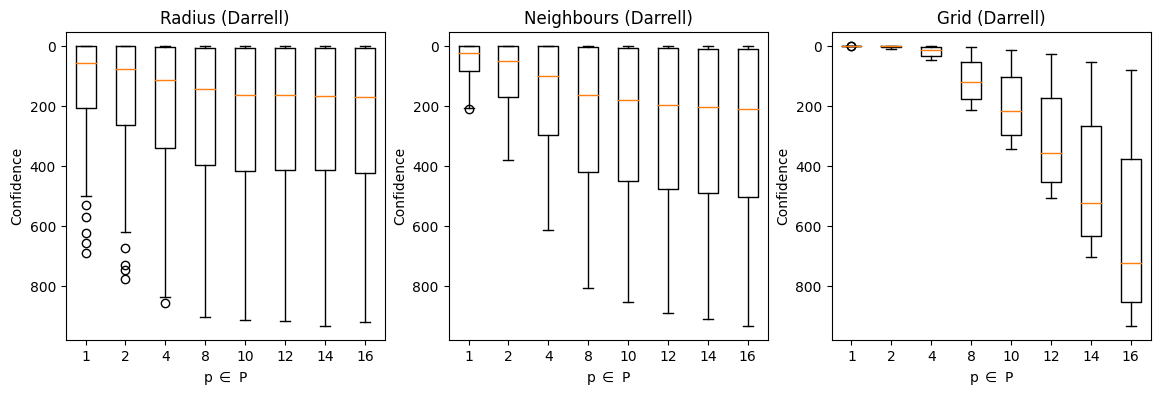

In [9]:
# Title for each plot (parameter names)
titles = ["Radius", "Neighbours", "Grid"]

# Plot each set of stats
for results, name in zip([results_steve, results_darrell], ["Steve", "Darrell"]):
    plt.figure(figsize=(14, 4))
    for idx in range(3):
        stats = [[conf for params, conf in results.items() if params[idx] == n] for n in gs_values]
        plt.subplot(1, 3, idx + 1)
        plot_stats(stats, gs_values, f"{titles[idx]} ({name})")
    plt.show()

<p>
The first result for the plot "Grid (Steve)" is difficult to make out, so let's take a closer look: the first 3 quartiles are less than 0.5 (in fact, you'd have to go to the 77th percentile to go above 0.5), and even the outliers are quite small.
</p>

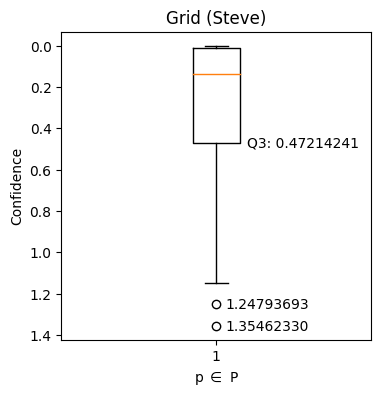

In [10]:
# Use only the first grid search value for grid
values = gs_values[:1]
stats_steve = [[conf for params, conf in results_steve.items() if params[2] == n] for n in values][0]

# Compute outliers
q1 = np.percentile(stats_steve, 25)
q3 = np.percentile(stats_steve, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = [x for x in stats_steve if x < lower_bound or x > upper_bound]

# Boxplot the data
plt.figure(figsize=(4, 4))
plot_stats(stats_steve, values, "Grid (Steve)")
plt.text(1.1, q3, f"Q3: {q3:.8f}", ha="left", va="center", fontsize=10)
for ol in outliers:
    plt.text(1.03, ol+0.005, f"{ol:.8f}", ha="left", va="center", fontsize=10)
plt.show()

# Conclusion

<p>
This notebook has walked through a simple facial recognition setup. Freely available libraries such as <a href="https://opencv.org/">OpenCV</a> make the task very easy for a technically minded person, but the real skill in implementing a production system is in the tuning of parameters. We saw above that the best scores were from the wrong face being identified. This demonstrates the importance of careful testing under real-life conditions in order to create a model that not only correctly identifies a user, but also avoids false positives.
</p>